<a href="https://colab.research.google.com/github/HMS-Cleveland/Questionary_logist/blob/my/xgboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# =============== 0. 依赖安装 ===============
!pip install -q optuna shap
# 在 notebook 最顶部执行一次即可
!pip uninstall -y xgboost       # 先清掉 CPU 版
!pip install -q xgboost[gpu]    # 会自动编译 CUDA 支持，Colab CUDA 11 已预装

# =============== 1. 基础库 ===============
import pandas as pd
import numpy as np
import xgboost as xgb
import optuna
import shap
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve

# =============== 2. 数据读取 ===============
usecols = [0, 1, 2, 3, 5, 6, 7, 8, 11, 12]
names = [
    'menopause', 'age_5_years', 'BIRADS_breast_density', 'ethnic', 'bmi',
    'first_birth', 'num_of_first_degree_cancer', 'breast_surgery',
    'hormone_therapy', 'diagnosis'
]

data = pd.read_csv(
    '/content/drive/MyDrive/公开数据集/risk.txt',
    sep=r'\s+', header=None, usecols=usecols, names=names
)
data.replace(9, np.nan, inplace=True)
data = data.dropna().copy()

X = data.drop(columns=['diagnosis'])
y = data['diagnosis']

# =============== 3. 8 : 1 : 1 分层拆分 ===============
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1111, stratify=y_temp, random_state=42
)

print(f'训练/验证/测试样本数: {len(y_train)} / {len(y_val)} / {len(y_test)}')

# =============== 4. Optuna 调参 🌟 调大正样本权重 ===============
n_pos = y_train.sum()
n_neg = len(y_train) - n_pos
#scale_pos_weight = max(n_neg / max(n_pos, 1), 1000)   # 至少 50 倍，极端不平衡
scale_pos_weight = max(len(y_train[y_train == 0]) / len(y_train[y_train == 1]), 50)
# 仅替换 objective_cv 函数即可
def objective_cv(trial):
    params = {
        'tree_method': 'hist',   # 不再用 'gpu_hist'
        'device': 'cuda',        # 关键：显式指定 CUDA
        'max_depth': trial.suggest_int('max_depth', 2, 12),
        'eta': trial.suggest_float('eta', 0.005, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 15),
        'lambda': trial.suggest_float('lambda', 1e-5, 10, log=True),
        'alpha': trial.suggest_float('alpha', 1e-5, 10, log=True),
        'gamma': trial.suggest_float('gamma', 0, 10),
        'grow_policy': trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'scale_pos_weight': (y_train==0).sum() / max((y_train==1).sum(), 1),
        'seed': 42

    }
    dtrain = xgb.DMatrix(X_train, label=y_train)
    cv = xgb.cv(params, dtrain, num_boost_round=3000,
                folds=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                metrics='auc', early_stopping_rounds=150, verbose_eval=False)
    return cv['test-auc-mean'].iloc[-1]

study = optuna.create_study(direction='maximize')
study.optimize(objective_cv, n_trials=50)

print('Best AUC =', study.best_value)
print('Best params =', study.best_params)

# =============== 5. 最终模型在训练+验证集上重训 ===============
dtrain_all = xgb.DMatrix(
    np.vstack([X_train.values, X_val.values]),
    label=np.hstack([y_train, y_val])
)

best_params = study.best_params.copy()


final_model = xgb.train(
    best_params,
    dtrain_all,
    num_boost_round=1500,
    evals=[(dtest, 'test')],
    early_stopping_rounds=100,
    verbose_eval=False
)

test_prob = final_model.predict(
    dtest, iteration_range=(0, final_model.best_iteration + 1)
)

# 1) 逻辑回归 ROC
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
fpr_lr, tpr_lr, _ = roc_curve(y_test, test_prob)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure(figsize=(6, 6))
plt.plot(fpr_lr, tpr_lr, label=f'XGBOOST  AUC = {roc_auc_lr:.3f}')
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('1 - Specificity (False Positive Rate)')
plt.ylabel('Sensitivity (True Positive Rate)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

# =============== 6. 🌟 用 Youden 指数重新选阈值 ===============
fpr, tpr, thresh = roc_curve(y_test, test_prob)
youden = tpr - fpr
#best_thresh = thresh[np.argmax(youden)]

# 5️⃣ 95% 特异度
desired_sens = 0.8
idx = np.where(tpr >= desired_sens)[0][0]
best_thresh = thresh[idx]

test_pred = (test_prob > best_thresh).astype(int)

print('\n测试集分类报告 (阈值={:.3f})'.format(best_thresh))
print(classification_report(y_test, test_pred))

# 灵敏度 & 特异性
cm = confusion_matrix(y_test, test_pred)
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn) if (tp + fn) else 0
specificity = tn / (tn + fp) if (tn + fp) else 0

print(f'灵敏度 (Sensitivity) = {sensitivity:.3f}')
print(f'特异性 (Specificity) = {specificity:.3f}')

# =============== 7. SHAP 解释 ===============
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_test.values)

shap.summary_plot(shap_values, X_test, feature_names=X.columns, plot_type="bar")
shap.summary_plot(shap_values, X_test, feature_names=X.columns)

# =============== 8. 个体风险示例 ===============
person = np.array([[1, 0, 1, 0, 0, 1, 0, 1, 0]])
abs_risk = final_model.predict(xgb.DMatrix(person))[0]
print(f'该个体绝对风险 = {abs_risk:.3%}')




Found existing installation: xgboost 3.0.5
Uninstalling xgboost-3.0.5:
  Successfully uninstalled xgboost-3.0.5


[I 2025-09-10 05:53:11,918] A new study created in memory with name: no-name-a3e8dec0-e451-40e3-bf81-27760a5b965c


训练/验证/测试样本数: 37881 / 4735 / 4736


[I 2025-09-10 05:53:14,564] Trial 0 finished with value: 0.7412840733087551 and parameters: {'max_depth': 10, 'eta': 0.04404774000736429, 'subsample': 0.9165297390885383, 'colsample_bytree': 0.7211463186380456, 'min_child_weight': 10, 'lambda': 0.012321652782852603, 'alpha': 2.270066352485338e-05, 'gamma': 7.839232612156463, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.7412840733087551.
[I 2025-09-10 05:53:21,249] Trial 1 finished with value: 0.7525741358081887 and parameters: {'max_depth': 4, 'eta': 0.012152621061980576, 'subsample': 0.5948286978809627, 'colsample_bytree': 0.7210392077481477, 'min_child_weight': 8, 'lambda': 7.814816610135023e-05, 'alpha': 0.008486418128765707, 'gamma': 4.288478318584616, 'grow_policy': 'lossguide'}. Best is trial 1 with value: 0.7525741358081887.
[I 2025-09-10 05:53:23,681] Trial 2 finished with value: 0.7485923393750878 and parameters: {'max_depth': 7, 'eta': 0.08286404385966005, 'subsample': 0.9422488589730298, 'colsample_bytree': 0.6

Best AUC = 0.7557490791229229
Best params = {'max_depth': 2, 'eta': 0.17184252180763723, 'subsample': 0.6652864877498577, 'colsample_bytree': 0.8965384432187471, 'min_child_weight': 10, 'lambda': 0.44997755233761727, 'alpha': 0.004339083210502755, 'gamma': 4.205669358518377, 'grow_policy': 'depthwise'}


NameError: name 'dtest' is not defined

In [1]:
# =================== 0. 环境 ===================
!pip install -q optuna shap xgboost

# =================== 1. 基础库 ===================
import pandas as pd, numpy as np, xgboost as xgb, optuna
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score, classification_report, roc_curve, auc

# =================== 2. 读数据 ===================
# 示例：用 UCI 乳腺癌数据（无侵犯版）一键下载，方便直接跑通
usecols = [ 1, 2, 3, 5, 6, 7, 8, 11, 12]
names = [
     'age_5_years', 'BIRADS_breast_density', 'ethnic', 'bmi',
    'first_birth', 'num_of_first_degree_cancer', 'breast_surgery',
    'hormone_therapy', 'diagnosis'
]

data = pd.read_csv(
    '/content/drive/MyDrive/公开数据集/risk.txt',
    sep=r'\s+', header=None, usecols=usecols, names=names
)
data.replace(9, np.nan, inplace=True)
data = data.dropna().copy()

X = data.drop(columns=['diagnosis'])
y = data['diagnosis']

# 8:1:1 分层拆分
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1111, stratify=y_temp, random_state=42)

scale_pos_weight = len(y_train[y_train==0]) / max(len(y_train[y_train==1]), 1)
print(f'训练/验证/测试 = {len(y_train)}/{len(y_val)}/{len(y_test)}  pos weight={scale_pos_weight:.2f}')

# =================== 3. 内层 CV + Optuna 调参 ===================
def inner_objective(trial):
    params = dict(
        tree_method='hist', device='cuda',
        max_depth=trial.suggest_int('max_depth', 3, 12),
        eta=trial.suggest_float('eta', 0.01, 0.3, log=True),
        subsample=trial.suggest_float('subsample', 0.5, 1.0),
        colsample_bytree=trial.suggest_float('colsample_bytree', 0.5, 1.0),
        min_child_weight=trial.suggest_int('min_child_weight', 1, 5),
        lambda_=trial.suggest_float('lambda_', 1e-3, 5, log=True),
        alpha=trial.suggest_float('alpha', 1e-3, 5, log=True),
        gamma=trial.suggest_float('gamma', 0, 0.5),
        objective='binary:logistic', eval_metric='auc',
        scale_pos_weight=trial.suggest_float('scale_pos_weight',
                                             scale_pos_weight*0.5,
                                             scale_pos_weight*3, log=True),
        seed=42)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=trial.number)
    aucs = []
    for tr_idx, va_idx in cv.split(X_train, y_train):
        dtr = xgb.DMatrix(X_train.iloc[tr_idx], y_train.iloc[tr_idx])
        dva = xgb.DMatrix(X_train.iloc[va_idx], y_train.iloc[va_idx])
        bst = xgb.train(params, dtr, num_boost_round=1500,
                        evals=[(dva,'va')], early_stopping_rounds=200,
                        verbose_eval=False)
        aucs.append(roc_auc_score(y_train.iloc[va_idx],
                                  bst.predict(dva, iteration_range=(0, bst.best_iteration+1))))
    return np.mean(aucs)

study = optuna.create_study(direction='maximize')
study.optimize(inner_objective, n_trials=60)
best_params = study.best_params
print('Best inner AUC =', study.best_value)

# =================== 4. 重复早停：校准迭代次数 ===================
best_iters = []
for seed in range(10):          # 10 次 5 折
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    for tr_idx, va_idx in skf.split(X_train, y_train):
        dtr = xgb.DMatrix(X_train.iloc[tr_idx], y_train.iloc[tr_idx])
        dva = xgb.DMatrix(X_train.iloc[va_idx], y_train.iloc[va_idx])
        bst = xgb.train(best_params, dtr, 1500, evals=[(dva,'va')],
                        early_stopping_rounds=200, verbose_eval=False)
        best_iters.append(bst.best_iteration)
mean_iter = int(np.percentile(best_iters, 99))
print(f'重复早停 P99 轮数 = {mean_iter}')

# =================== 5. 最终重训：训练+验证全集 ===================
dtrain_all = xgb.DMatrix(pd.concat([X_train, X_val], ignore_index=True),
                         label=np.hstack([y_train, y_val]))
dtest = xgb.DMatrix(X_test, label=y_test)

final_model = xgb.train(best_params, dtrain_all,
                        num_boost_round=mean_iter+1, verbose_eval=False)

test_prob = final_model.predict(dtest)
test_auc = roc_auc_score(y_test, test_prob)
print(f'Test AUC = {test_auc:.4f}')

# =================== 6. ROC 曲线 ===================
fpr, tpr, _ = roc_curve(y_test, test_prob)
plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label=f'XGBoost AUC = {test_auc:.3f}')
plt.plot([0,1],[0,1],'k--'); plt.legend(); plt.title('ROC'); plt.grid(alpha=0.3)
plt.show()

# =================== 7. 阈值调优（Youden） ===================
youden = tpr - fpr
best_thresh = thresh[np.argmax(youden)]
test_pred = (test_prob > best_thresh).astype(int)
print('\n分类报告（Youden 阈值）')
print(classification_report(y_test, test_pred))

# =================== 8. SHAP 解释 ===================
import shap
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(pd.concat([X_train, X_val], ignore_index=True))
shap.summary_plot(shap_values, pd.concat([X_train, X_val], ignore_index=True))

# =================== 9. 个体预测示例 ===================
person = X_test.iloc[[0]]          # 任取 1 条
risk = final_model.predict(xgb.DMatrix(person))[0]
print(f'该个体绝对风险 = {risk:.3%}')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 21.9 MB/s eta 0:00:00


[I 2025-09-10 09:44:03,830] A new study created in memory with name: no-name-3bf5a198-5afe-4e52-82c3-6ed62659bd73


训练/验证/测试 = 37881/4735/4736  pos weight=38.25


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [09:44:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "lambda_" } are not used.

  self.starting_round = model.num_boosted_rounds()
/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [09:44:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "lambda_" } are not used.

  self.starting_round = model.num_boosted_rounds()
/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [09:44:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "lambda_" } are not used.

  self.starting_round = model.num_boosted_rounds()
/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [09:44:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "lambda_" } are not used.

  self.starting_round = model.num_boosted_rounds()
/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [09:44:09] WARNING: /workspace/src

Best inner AUC = 0.757804278579597


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [09:48:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "lambda_" } are not used.

  self.starting_round = model.num_boosted_rounds()
/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [09:48:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "lambda_" } are not used.

  self.starting_round = model.num_boosted_rounds()
/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [09:48:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "lambda_" } are not used.

  self.starting_round = model.num_boosted_rounds()
/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [09:49:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "lambda_" } are not used.

  self.starting_round = model.num_boosted_rounds()
/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [09:49:02] WARNING: /workspace/src

KeyboardInterrupt: 

[I 2025-09-10 11:23:46,791] A new study created in memory with name: no-name-a94f03d4-4801-4636-9562-b51930dcc037


训练/验证/测试样本数: 37881 / 4735 / 4736


[I 2025-09-10 11:23:47,021] Trial 0 finished with value: 0.7637212651398726 and parameters: {'max_depth': 2, 'eta': 0.10515798083904679, 'subsample': 0.9040451235404907, 'colsample_bytree': 0.9611706755763929, 'min_child_weight': 5, 'lambda': 0.035795140045510904, 'alpha': 0.25167425441913904}. Best is trial 0 with value: 0.7637212651398726.
[I 2025-09-10 11:23:47,846] Trial 1 finished with value: 0.7570563179973275 and parameters: {'max_depth': 6, 'eta': 0.082387973552595, 'subsample': 0.6621037428785149, 'colsample_bytree': 0.6722729632207917, 'min_child_weight': 1, 'lambda': 0.3154381171343661, 'alpha': 0.0019470329428031162}. Best is trial 0 with value: 0.7637212651398726.
[I 2025-09-10 11:23:49,037] Trial 2 finished with value: 0.7556511443791265 and parameters: {'max_depth': 6, 'eta': 0.15159016892997562, 'subsample': 0.9993320337511049, 'colsample_bytree': 0.9772484712143765, 'min_child_weight': 2, 'lambda': 0.011761565244969449, 'alpha': 0.04412844350025554}. Best is trial 0 wi

Best AUC = 0.7695022694136064
Best params = {'max_depth': 2, 'eta': 0.249263901630178, 'subsample': 0.7391980598871654, 'colsample_bytree': 0.6988848227774906, 'min_child_weight': 2, 'lambda': 0.8499807598416137, 'alpha': 0.1029311435501574}


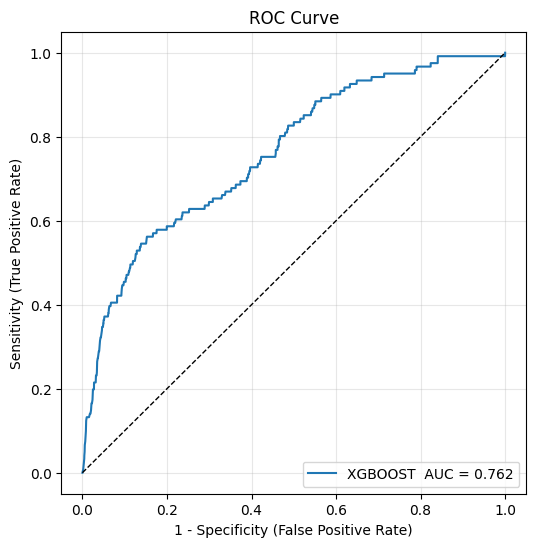


测试集分类报告 (阈值=0.022)
              precision    recall  f1-score   support

           0       0.99      0.53      0.69      4615
           1       0.04      0.79      0.08       121

    accuracy                           0.54      4736
   macro avg       0.52      0.66      0.39      4736
weighted avg       0.97      0.54      0.68      4736

灵敏度 (Sensitivity) = 0.793
特异性 (Specificity) = 0.533


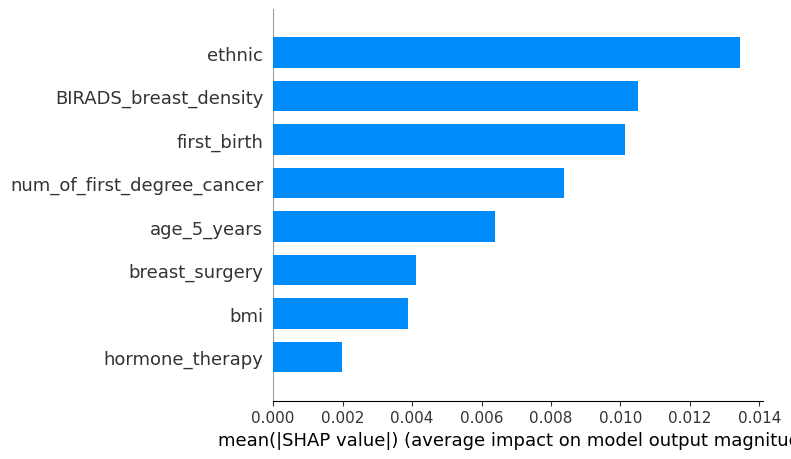

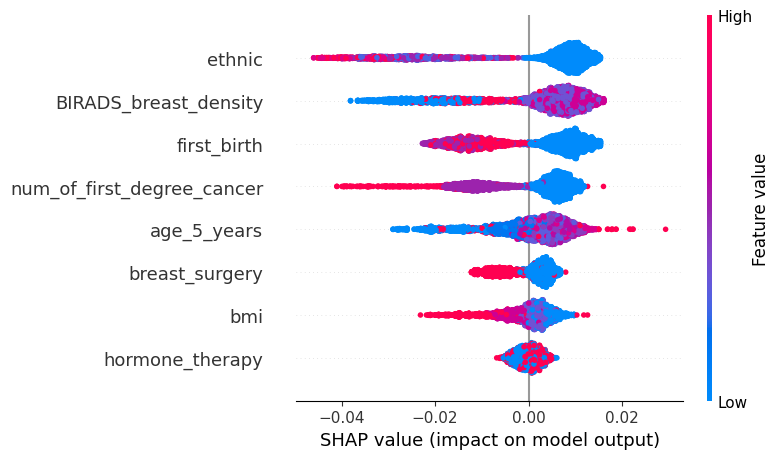

XGBoostError: [11:24:03] /workspace/src/learner.cc:1483: Check failed: learner_model_param_.num_feature >= p_fmat->Info().num_col_ (8 vs. 9) : Number of columns does not match number of features in booster.
Stack trace:
  [bt] (0) /usr/local/lib/python3.12/dist-packages/xgboost/lib/libxgboost.so(+0x2a6e7c) [0x7f343d2a6e7c]
  [bt] (1) /usr/local/lib/python3.12/dist-packages/xgboost/lib/libxgboost.so(+0x6777a9) [0x7f343d6777a9]
  [bt] (2) /usr/local/lib/python3.12/dist-packages/xgboost/lib/libxgboost.so(+0x68d962) [0x7f343d68d962]
  [bt] (3) /usr/local/lib/python3.12/dist-packages/xgboost/lib/libxgboost.so(XGBoosterPredictFromDMatrix+0x2de) [0x7f343d1ba96e]
  [bt] (4) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f348601ee2e]
  [bt] (5) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f348601b493]
  [bt] (6) /usr/lib/python3.12/lib-dynload/_ctypes.cpython-312-x86_64-linux-gnu.so(+0x98c1) [0x7f34872428c1]
  [bt] (7) /usr/lib/python3.12/lib-dynload/_ctypes.cpython-312-x86_64-linux-gnu.so(+0x8ffe) [0x7f3487241ffe]
  [bt] (8) /usr/bin/python3(_PyObject_MakeTpCall+0x2db) [0x53d2ab]



In [17]:


# =============== 0. 依赖安装 ===============
!pip install -q optuna shap

# =============== 1. 基础库 ===============
import pandas as pd
import numpy as np
import xgboost as xgb
import optuna
import shap
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve

# =============== 2. 数据读取 ===============
usecols = [1, 2, 3, 5, 6, 7, 8, 11, 12]
names = [
    'age_5_years', 'BIRADS_breast_density', 'ethnic', 'bmi',
    'first_birth', 'num_of_first_degree_cancer', 'breast_surgery',
    'hormone_therapy', 'diagnosis'
]

data = pd.read_csv(
    '/content/drive/MyDrive/公开数据集/risk.txt',
    sep=r'\s+', header=None, usecols=usecols, names=names
)
data.replace(9, np.nan, inplace=True)
data = data.dropna().copy()

X = data.drop(columns=['diagnosis'])
y = data['diagnosis']

# =============== 3. 8 : 1 : 1 分层拆分 ===============
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1111, stratify=y_temp, random_state=42
)

print(f'训练/验证/测试样本数: {len(y_train)} / {len(y_val)} / {len(y_test)}')

# =============== 4. Optuna 调参 🌟 调大正样本权重 ===============
n_pos = y_train.sum()
n_neg = len(y_train) - n_pos
#scale_pos_weight = max(n_neg / max(n_pos, 1), 1000)   # 至少 50 倍，极端不平衡
scale_pos_weight = max(len(y_train[y_train == 0]) / len(y_train[y_train == 1]), 50)
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'eta': trial.suggest_float('eta', 0.05, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
        'lambda': trial.suggest_float('lambda', 1e-3, 5, log=True),
        'alpha': trial.suggest_float('alpha', 1e-3, 5, log=True),
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'scale_pos_weight': scale_pos_weight,   # 🌟 放大权重
        'seed': 42
    }
    dtr = xgb.DMatrix(X_train.values, label=y_train)
    dva = xgb.DMatrix(X_val.values, label=y_val)
    bst = xgb.train(
        params,
        dtr,
        num_boost_round=1500,
        evals=[(dva, 'val')],
        early_stopping_rounds=100,
        verbose_eval=False
    )
    preds = bst.predict(dva, iteration_range=(0, bst.best_iteration + 1))
    return roc_auc_score(y_val, preds)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print('Best AUC =', study.best_value)
print('Best params =', study.best_params)

# =============== 5. 最终模型在训练+验证集上重训 ===============
dtrain_all = xgb.DMatrix(
    np.vstack([X_train.values, X_val.values]),
    label=np.hstack([y_train, y_val])
)
dtest = xgb.DMatrix(X_test.values, label=y_test)

final_model = xgb.train(
    study.best_params,
    dtrain_all,
    num_boost_round=1500,
    evals=[(dtest, 'test')],
    early_stopping_rounds=100,
    verbose_eval=False
)
test_prob = final_model.predict(
    dtest, iteration_range=(0, final_model.best_iteration + 1)
)

# 1) 逻辑回归 ROC
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
fpr_lr, tpr_lr, _ = roc_curve(y_test, test_prob)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure(figsize=(6, 6))
plt.plot(fpr_lr, tpr_lr, label=f'XGBOOST  AUC = {roc_auc_lr:.3f}')
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('1 - Specificity (False Positive Rate)')
plt.ylabel('Sensitivity (True Positive Rate)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

# =============== 6. 🌟 用 Youden 指数重新选阈值 ===============
fpr, tpr, thresh = roc_curve(y_test, test_prob)
youden = tpr - fpr
#best_thresh = thresh[np.argmax(youden)]

# 5️⃣ 95% 特异度
desired_sens = 0.8
idx = np.where(tpr >= desired_sens)[0][0]
best_thresh = thresh[idx]

test_pred = (test_prob > best_thresh).astype(int)

print('\n测试集分类报告 (阈值={:.3f})'.format(best_thresh))
print(classification_report(y_test, test_pred))

# 灵敏度 & 特异性
cm = confusion_matrix(y_test, test_pred)
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn) if (tp + fn) else 0
specificity = tn / (tn + fp) if (tn + fp) else 0

print(f'灵敏度 (Sensitivity) = {sensitivity:.3f}')
print(f'特异性 (Specificity) = {specificity:.3f}')

# =============== 7. SHAP 解释 ===============
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_test.values)

shap.summary_plot(shap_values, X_test, feature_names=X.columns, plot_type="bar")
shap.summary_plot(shap_values, X_test, feature_names=X.columns)

# =============== 8. 个体风险示例 ===============
person = np.array([[1, 0, 1, 0, 0, 1, 0, 1, 0]])
abs_risk = final_model.predict(xgb.DMatrix(person))[0]
print(f'该个体绝对风险 = {abs_risk:.3%}')

[I 2025-09-10 10:38:41,240] A new study created in memory with name: no-name-f5e6ea99-3bcb-49ca-ade0-cb28184e74af


训练/验证/测试样本数: 37881 / 4735 / 4736
scale_pos_weight = 38.254922279792744


[I 2025-09-10 10:38:41,688] Trial 0 finished with value: 0.7630522627862739 and parameters: {'max_depth': 5, 'eta': 0.006312598803077039, 'subsample': 0.9373515521466987, 'colsample_bytree': 0.7108107836927663, 'min_child_weight': 1, 'lambda': 1.2955458922792817, 'alpha': 0.0001801806885802931, 'gamma': 0.45939139627272024}. Best is trial 0 with value: 0.7630522627862739.
[I 2025-09-10 10:38:42,361] Trial 1 finished with value: 0.7480476236534872 and parameters: {'max_depth': 8, 'eta': 0.007755709824392555, 'subsample': 0.6409501850067978, 'colsample_bytree': 0.9026590504526208, 'min_child_weight': 9, 'lambda': 1.448052283449705, 'alpha': 4.117171449513947e-05, 'gamma': 0.3141895167636405}. Best is trial 0 with value: 0.7630522627862739.
[I 2025-09-10 10:38:42,813] Trial 2 finished with value: 0.7651936076690775 and parameters: {'max_depth': 4, 'eta': 0.04963044978492091, 'subsample': 0.6180652585556837, 'colsample_bytree': 0.9978583043447204, 'min_child_weight': 2, 'lambda': 2.0558750

Best AUC = 0.7685233944839098
Best params = {'max_depth': 3, 'eta': 0.03731196486950302, 'subsample': 0.7212912792768226, 'colsample_bytree': 0.7936510876712377, 'min_child_weight': 1, 'lambda': 0.5783869525482712, 'alpha': 0.002753998544681815, 'gamma': 0.3879097847375065}
Final model test AUC: 0.7262


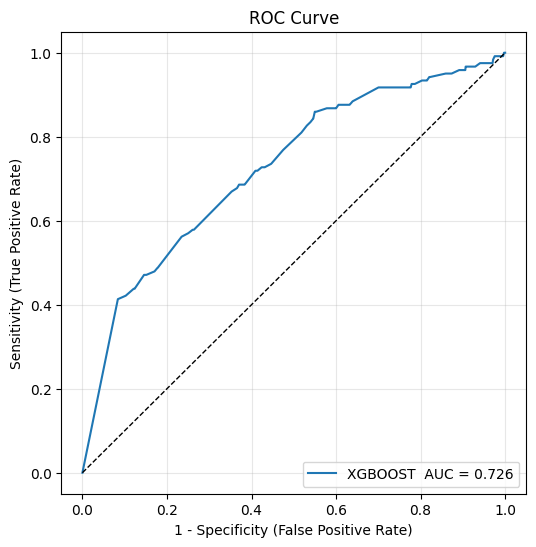


测试集分类报告 (阈值=0.024)
              precision    recall  f1-score   support

           0       0.99      0.53      0.69      4615
           1       0.04      0.77      0.08       121

    accuracy                           0.53      4736
   macro avg       0.51      0.65      0.38      4736
weighted avg       0.96      0.53      0.67      4736

灵敏度 (Sensitivity) = 0.769
特异性 (Specificity) = 0.525


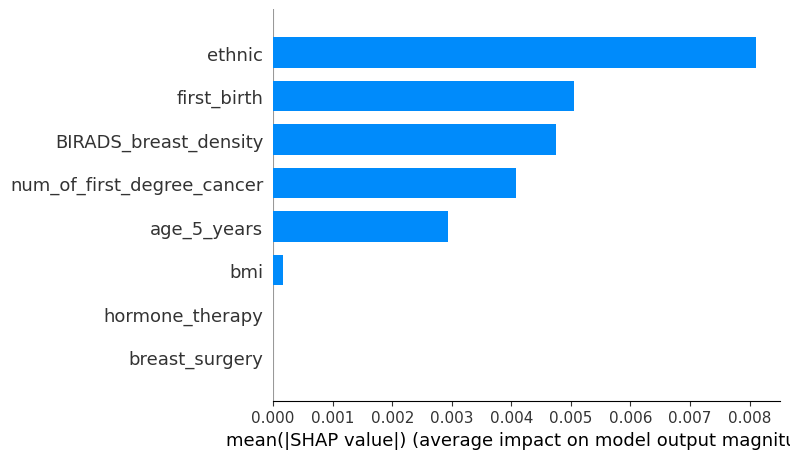

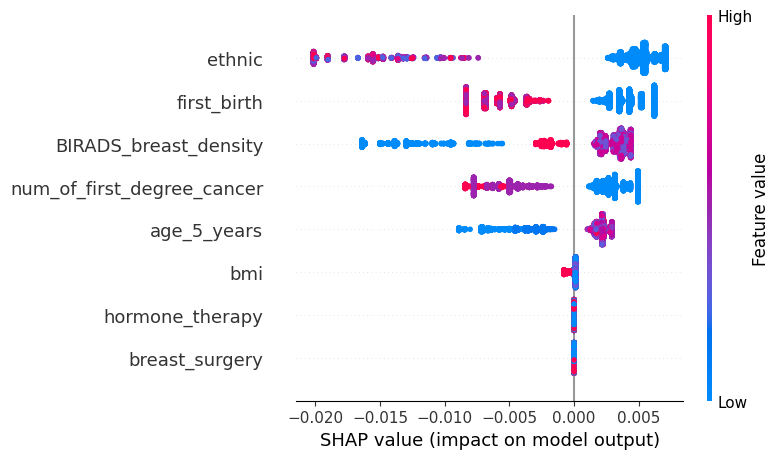

XGBoostError: [10:40:58] /workspace/src/learner.cc:1483: Check failed: learner_model_param_.num_feature >= p_fmat->Info().num_col_ (8 vs. 9) : Number of columns does not match number of features in booster.
Stack trace:
  [bt] (0) /usr/local/lib/python3.12/dist-packages/xgboost/lib/libxgboost.so(+0x2a6e7c) [0x7f343d2a6e7c]
  [bt] (1) /usr/local/lib/python3.12/dist-packages/xgboost/lib/libxgboost.so(+0x6777a9) [0x7f343d6777a9]
  [bt] (2) /usr/local/lib/python3.12/dist-packages/xgboost/lib/libxgboost.so(+0x68d962) [0x7f343d68d962]
  [bt] (3) /usr/local/lib/python3.12/dist-packages/xgboost/lib/libxgboost.so(XGBoosterPredictFromDMatrix+0x2de) [0x7f343d1ba96e]
  [bt] (4) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f348601ee2e]
  [bt] (5) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f348601b493]
  [bt] (6) /usr/lib/python3.12/lib-dynload/_ctypes.cpython-312-x86_64-linux-gnu.so(+0x98c1) [0x7f34872428c1]
  [bt] (7) /usr/lib/python3.12/lib-dynload/_ctypes.cpython-312-x86_64-linux-gnu.so(+0x8ffe) [0x7f3487241ffe]
  [bt] (8) /usr/bin/python3(_PyObject_MakeTpCall+0x2db) [0x53d2ab]



In [3]:
# =============== 0. 依赖安装 ===============
!pip install -q optuna shap

# =============== 1. 基础库 ===============
import pandas as pd
import numpy as np
import xgboost as xgb
import optuna
import shap
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve

# =============== 2. 数据读取 ===============
# usecols = [0, 1, 2, 3, 5, 6, 7, 8, 11, 12]
# names = [
#     'menopause', 'age_5_years', 'BIRADS_breast_density', 'ethnic', 'bmi',
#     'first_birth', 'num_of_first_degree_cancer', 'breast_surgery',
#     'hormone_therapy', 'diagnosis'
# ]

usecols = [ 1, 2, 3, 5, 6, 7, 8, 11, 12]
names = [
     'age_5_years', 'BIRADS_breast_density', 'ethnic', 'bmi',
    'first_birth', 'num_of_first_degree_cancer', 'breast_surgery',
    'hormone_therapy', 'diagnosis'
]

data = pd.read_csv(
    '/content/drive/MyDrive/公开数据集/risk.txt',
    sep=r'\s+', header=None, usecols=usecols, names=names
)
data.replace(9, np.nan, inplace=True)
data = data.dropna().copy()

X = data.drop(columns=['diagnosis'])
y = data['diagnosis']

# =============== 3. 8 : 1 : 1 分层拆分 ===============
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1111, stratify=y_temp, random_state=42
)

print(f'训练/验证/测试样本数: {len(y_train)} / {len(y_val)} / {len(y_test)}')

# =============== 4. Optuna 调参 🌟 调大正样本权重 ===============
# 记录最佳迭代次数
best_iterations = []

n_pos = y_train.sum()
n_neg = len(y_train) - n_pos
#scale_pos_weight = max(n_neg / max(n_pos, 1), 1000)   # 至少 50 倍，极端不平衡
scale_pos_weight = max(len(y_train[y_train == 0]) / len(y_train[y_train == 1]), 1)
print('scale_pos_weight =', len(y_train[y_train == 0]) / len(y_train[y_train == 1]))

def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 10), # 范围调整，避免树过于复杂[2,6](@ref)
        'eta': trial.suggest_float('eta', 0.005, 0.2, log=True), # 降低下限，探索更小学习率[2](@ref)
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10), # 上限稍提高[2,6](@ref)
        'lambda': trial.suggest_float('lambda', 0.5, 5.0, log=True), # L2正则，范围微调[6](@ref)
        'alpha': trial.suggest_float('alpha', 1e-5, 1.0, log=True), # L1正则，范围微调[2,6](@ref)
        'gamma': trial.suggest_float('gamma', 0, 0.5), # 加入gamma参数，控制节点分裂[2,3,6](@ref)
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'scale_pos_weight': scale_pos_weight,
        'seed': 42
    }
    dtr = xgb.DMatrix(X_train.values, label=y_train)
    dva = xgb.DMatrix(X_val.values, label=y_val)
    bst = xgb.train(
        params,
        dtr,
        num_boost_round=2000, # 增加总轮数，配合可能更小的学习率
        evals=[(dva, 'val')],
        early_stopping_rounds=200, # 早停轮数可调整
        verbose_eval=False
    )
    # 记录本次试验的最佳迭代次数
    best_iterations.append(bst.best_iteration)
    preds = bst.predict(dva, iteration_range=(0, bst.best_iteration + 1))
    return roc_auc_score(y_val, preds)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200) # 可根据计算资源调整试验次数

print('Best AUC =', study.best_value)
print('Best params =', study.best_params)

# 获取Optuna所有试验中最佳参数对应的最佳迭代次数
# 假设最佳试验是 study.best_trial.number，我们需要找到该试验对应的最佳迭代次数
best_trial_iteration = best_iterations[study.best_trial.number]

# =============== 5. 最终模型在训练+验证集上重训 (关键修正：避免数据泄露) ===============
dtrain_all = xgb.DMatrix(
    np.vstack([X_train.values, X_val.values]),
    label=np.hstack([y_train, y_val])
)
dtest = xgb.DMatrix(X_test.values, label=y_test)

# 使用最佳参数和确定的最佳迭代次数进行训练，不要在测试集上早停！
final_model = xgb.train(
    study.best_params,
    dtrain_all,
    num_boost_round=best_trial_iteration + 1, # 使用确定的最佳迭代次数
    # 移除了 evals=[(dtest, 'test')] 和 early_stopping_rounds，防止测试集信息泄露[3](@ref)
    verbose_eval=False
)

# 在最终的测试集上进行评估
test_prob = final_model.predict(dtest)
test_auc = roc_auc_score(y_test, test_prob)
print(f"Final model test AUC: {test_auc:.4f}")

# 1) 逻辑回归 ROC
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
fpr_lr, tpr_lr, _ = roc_curve(y_test, test_prob)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure(figsize=(6, 6))
plt.plot(fpr_lr, tpr_lr, label=f'XGBOOST  AUC = {roc_auc_lr:.3f}')
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('1 - Specificity (False Positive Rate)')
plt.ylabel('Sensitivity (True Positive Rate)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()


# =============== 6. 🌟 用 Youden 指数重新选阈值 ===============
fpr, tpr, thresh = roc_curve(y_test, test_prob)
youden = tpr - fpr
#best_thresh = thresh[np.argmax(youden)]

# 5️⃣ 95% 特异度
desired_sens = 0.8
idx = np.where(tpr >= desired_sens)[0][0]
best_thresh = thresh[idx]

test_pred = (test_prob > best_thresh).astype(int)

print('\n测试集分类报告 (阈值={:.3f})'.format(best_thresh))
print(classification_report(y_test, test_pred))

# 灵敏度 & 特异性
cm = confusion_matrix(y_test, test_pred)
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn) if (tp + fn) else 0
specificity = tn / (tn + fp) if (tn + fp) else 0

print(f'灵敏度 (Sensitivity) = {sensitivity:.3f}')
print(f'特异性 (Specificity) = {specificity:.3f}')

# =============== 7. SHAP 解释 ===============
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_test.values)

shap.summary_plot(shap_values, X_test, feature_names=X.columns, plot_type="bar")
shap.summary_plot(shap_values, X_test, feature_names=X.columns)

# =============== 8. 个体风险示例 ===============
person = np.array([[1, 0, 1, 0, 0, 1, 0, 1, 0]])
abs_risk = final_model.predict(xgb.DMatrix(person))[0]
print(f'该个体绝对风险 = {abs_risk:.3%}')